<a href="https://colab.research.google.com/github/yadavrishikesh/BayesNF/blob/main/BayesNF_on_London_Air_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# London Air Quality Tutorial

<a
target="_blank" href="https://colab.research.google.com/github/google/bayesnf/blob/main/docs/tutorials/BayesNF_Tutorial_on_London_Air_Quality.ipynb">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [2]:
# Download latest version of bayesnf.
!pip install -q bayesnf

In [3]:
# Install Python libraries for plotting.
!pip -q install cartopy
!pip -q install contextily
!pip -q install geopandas

In [4]:
import warnings
warnings.simplefilter('ignore')

import contextily as ctx
import geopandas as gpd
import jax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from cartopy import crs as ccrs
from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Loading and Plotting Data

We analyze data from the London Air Quality Network <https://www.londonair.org.uk/>. The data contains air pollution levels measured by sensors across London, measured every hour.

In [5]:
#!wget -q https://cs.cmu.edu/~fsaad/assets/bayesnf/air_quality.5.train.csv
!wget -q https://raw.githubusercontent.com/yadavrishikesh/BayesNF/main/data/air_quality.5.train.csv
df_train = pd.read_csv('air_quality.5.train.csv', index_col=0, parse_dates=['datetime'])


BayesNF excepts dataframe to be  in "long" format. That is, each row shows a single observation of `pm10`, which measures the [atmospheric particulate matter](https://en.wikipedia.org/wiki/Particulates) at a given point in time (`datetime` column) and in space (`latitude` and `longitude` columns, which show the location of the sensor).

In [6]:
df_train.head(10)

,location,datetime,latitude,longitude,pm10
0,0,2018-12-31 19:00:00,51.35866,-0.149724,22.433324
1,0,2018-12-31 20:00:00,51.35866,-0.149724,19.833325
2,0,2018-12-31 21:00:00,51.35866,-0.149724,11.833329
3,0,2018-12-31 22:00:00,51.35866,-0.149724,10.833329
4,0,2018-12-31 23:00:00,51.35866,-0.149724,13.833328
5,0,2019-01-01 00:00:00,51.35866,-0.149724,14.433328
6,0,2019-01-01 01:00:00,51.35866,-0.149724,12.033329
7,0,2019-01-01 02:00:00,51.35866,-0.149724,13.233328
8,0,2019-01-01 03:00:00,51.35866,-0.149724,12.433328
9,0,2019-01-01 04:00:00,51.35866,-0.149724,13.633328


We can use the [`geopandas`](https://geopandas.org/en/stable/) library to plot snapshots of the data over the spatial field at different points in time.

In [7]:
!wget -q https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip
!unzip -oq statistical-gis-boundaries-london.zip

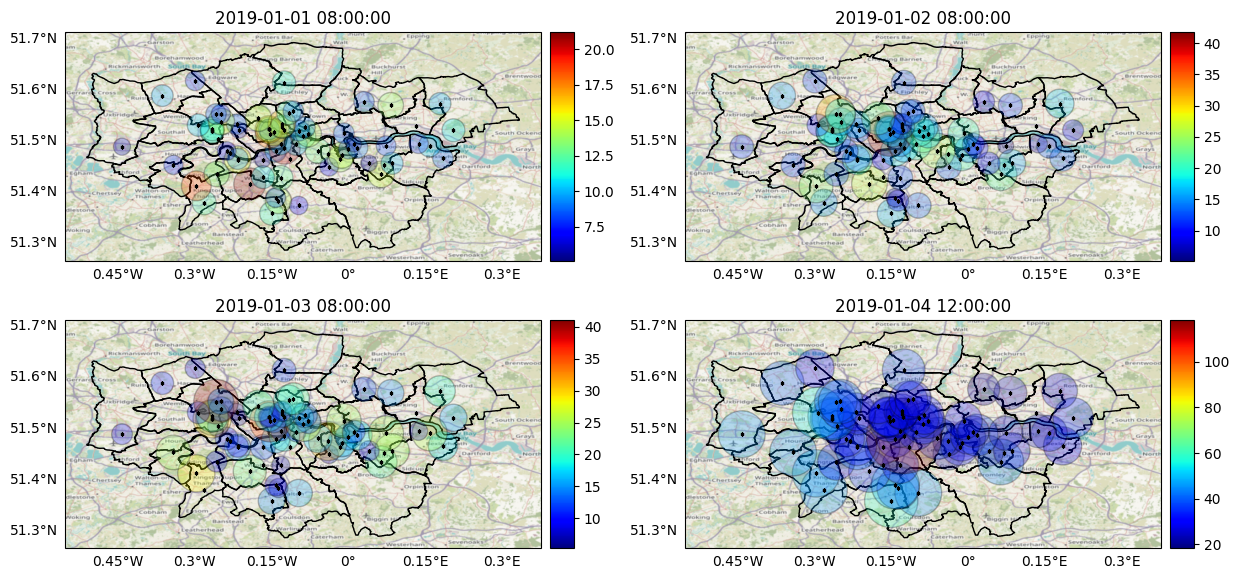

In [8]:
# Create a dataframe for plotting using geopandas.
london = gpd.read_file("statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")
london = london.to_crs(epsg=4326)
df_plot = df_train.copy()
stations = [Point(c) for c in zip(df_plot['longitude'], df_plot['latitude'])]

# Helper function to plot a single map.
def plot_map(date, ax):
  # Plot basemap.
  london.plot(color='none', edgecolor='black', linewidth=1, aspect=1, ax=ax)
  ctx.add_basemap(ax, crs=london.crs.to_string(), attribution='', zorder=-1)
  # Make legend axes.
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad='2%', axes_class=plt.matplotlib.axes.Axes)
  # Set date
  # Plot stations.
  df_plot_geo = gpd.GeoDataFrame(df_plot, crs=london.crs, geometry=stations)
  df_plot_geo_t0 = df_plot_geo[df_plot_geo.datetime==date]
  df_plot_geo_t0.plot(
      column='pm10',
      markersize=25*df_plot_geo_t0['pm10'].values,
      marker='o',
      alpha=.25, edgecolor='k', linewidth=1,
      legend=True,
      legend_kwds={'pad':5, 'orientation': 'vertical'},
      cmap=plt.colormaps['jet'],
      cax=cax,
      ax=ax,
      aspect=1,
      )
  ax.scatter(df_plot_geo_t0.longitude, df_plot_geo_t0.latitude, marker='s', s=4, color='k')
  gl = ax.gridlines(draw_labels=True, alpha=0)
  gl.top_labels = False
  gl.right_labels = False
  ax.set_title(date)

fig, axes = plt.subplots(
    nrows=2, ncols=2, subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(12.5, 12.5), tight_layout=True)

dates = ['2019-01-01 08:00:00', '2019-01-02 08:00:00', '2019-01-03 08:00:00', '2019-01-04 12:00:00']
for ax, date in zip(axes.flat, dates):
  plot_map(date, ax)

We can also plot the observed time series at 20 representative locations.

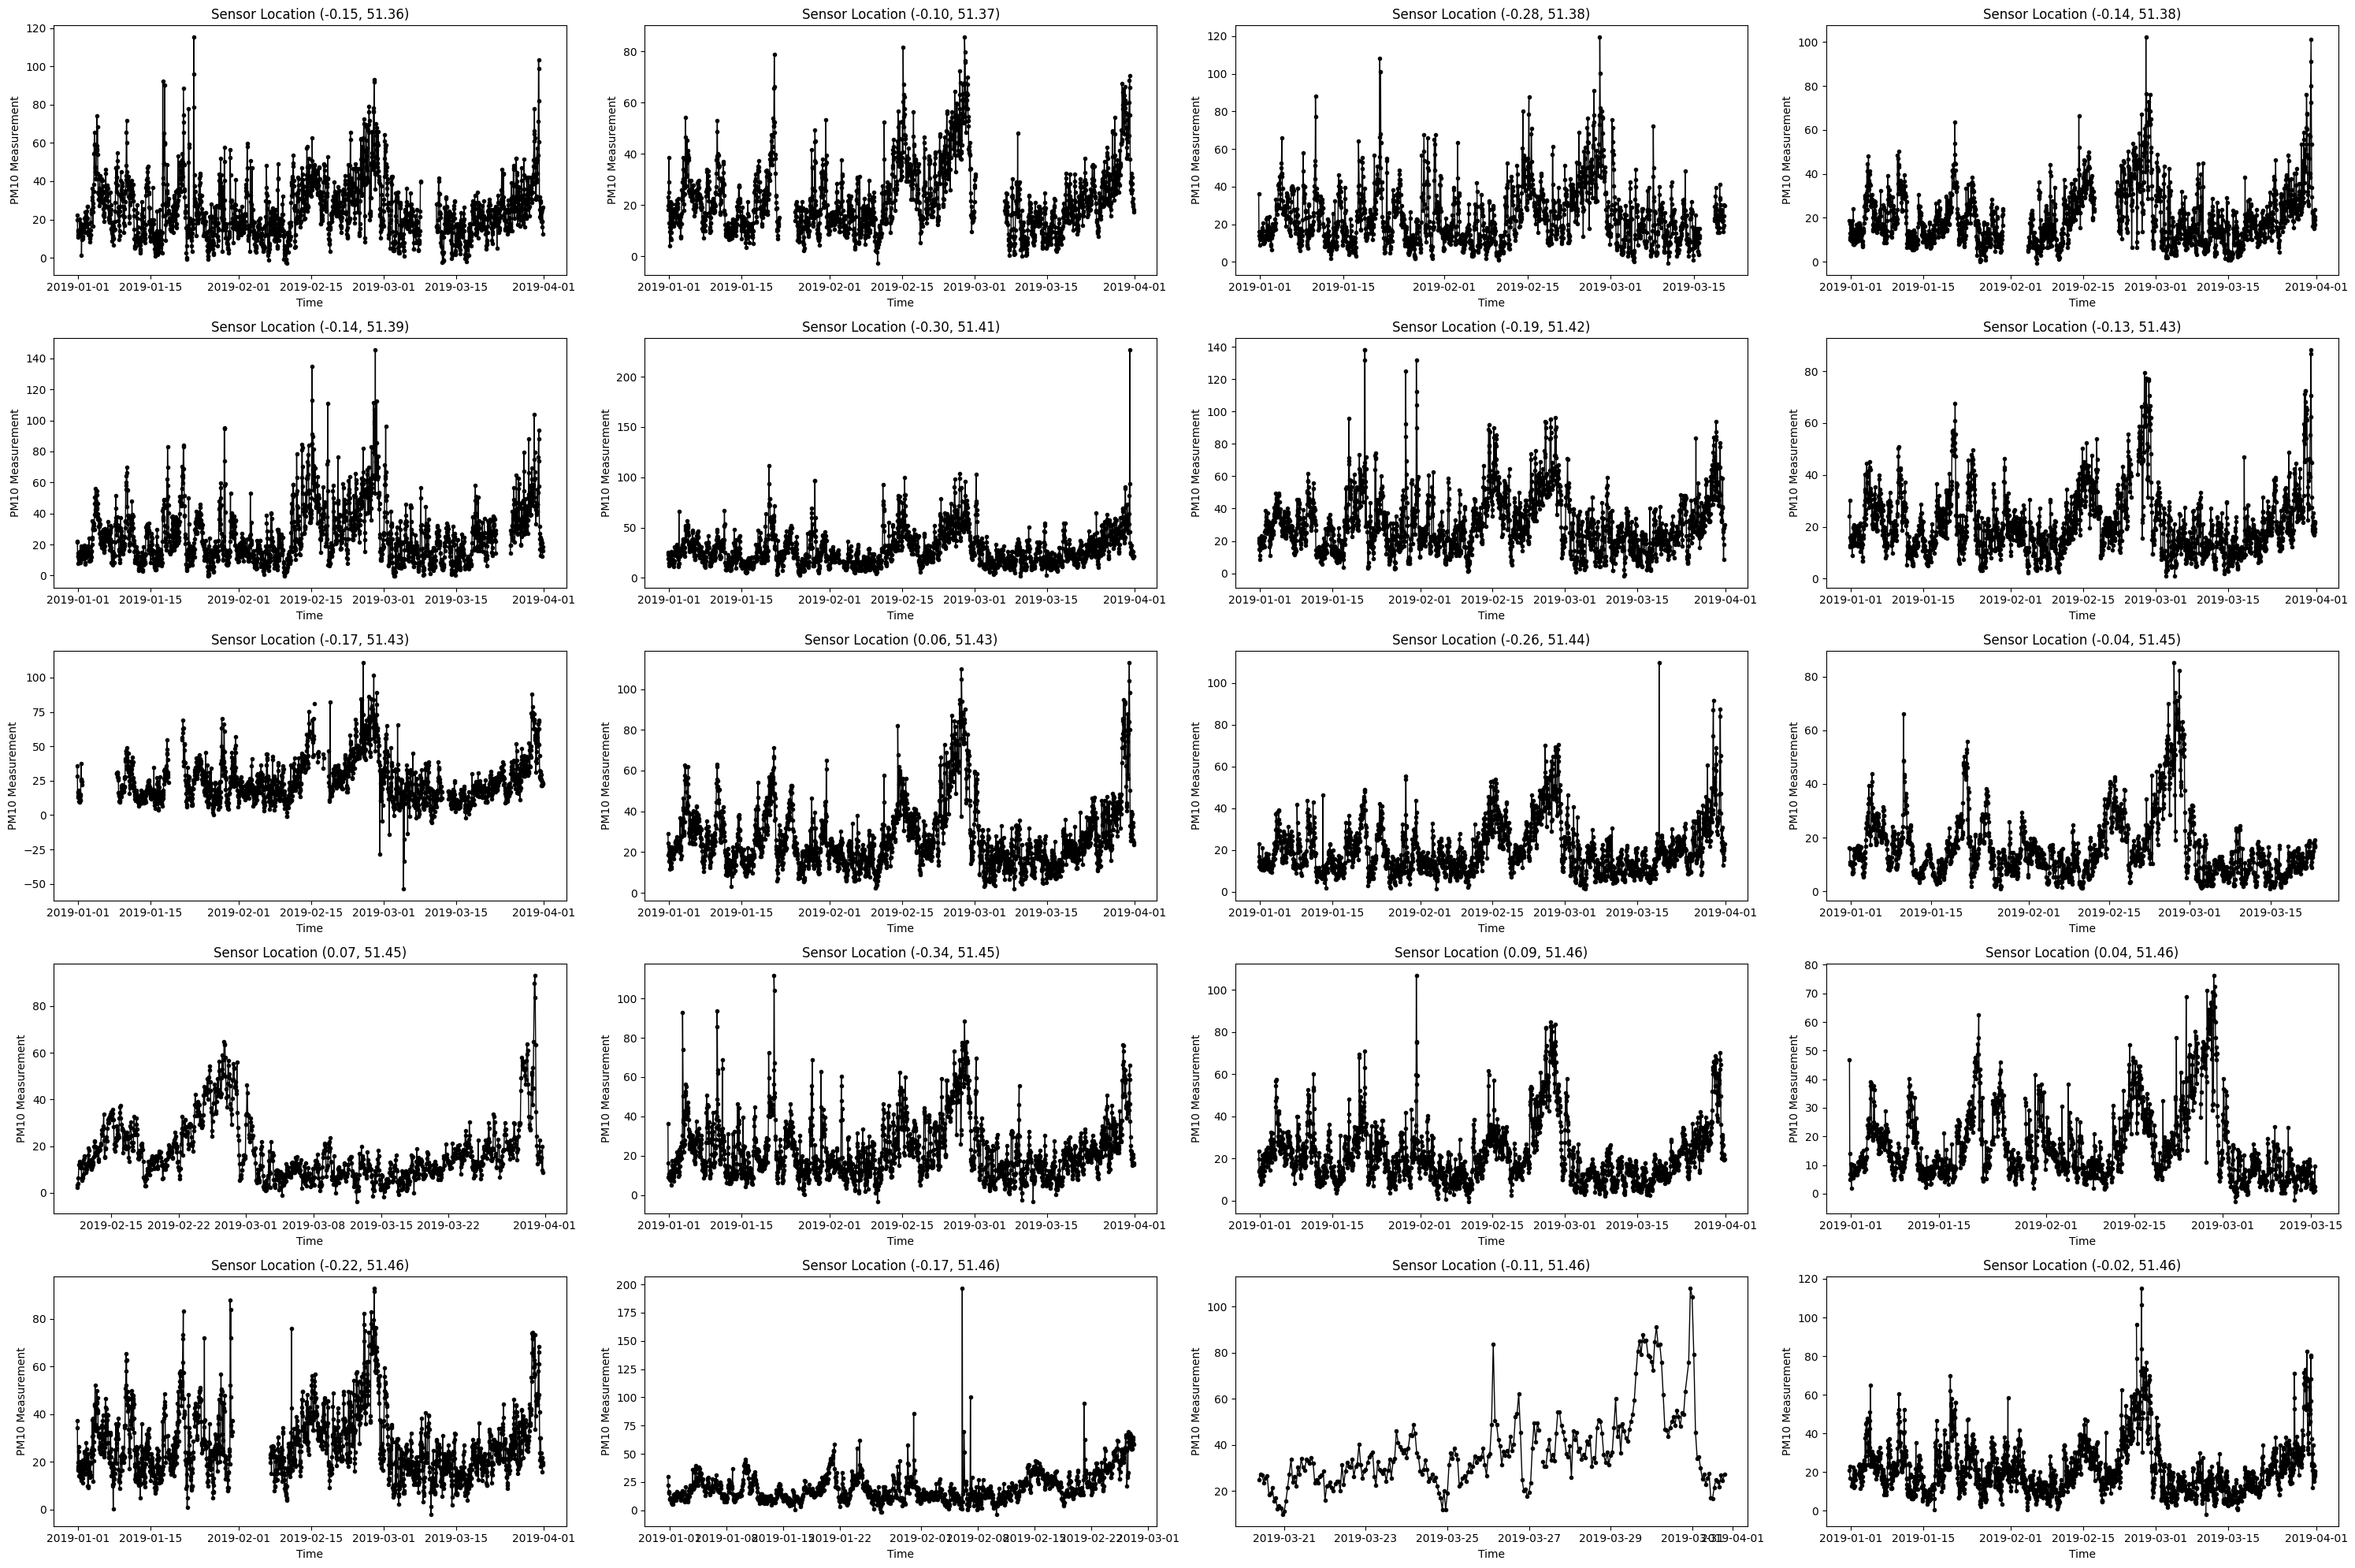

In [9]:
locations = df_train.location.unique()
fig, axes = plt.subplots(ncols=4, nrows=5, tight_layout=True, figsize=(30,20))
for ax, location in zip(axes.flat, locations):
  df_location = df_train[df_train.location==location]
  latitude, longitude = df_location.iloc[0][['latitude', 'longitude']]
  ax.plot(df_location.datetime, df_location.pm10, marker='.', color='k', linewidth=1)
  ax.set_title(f'Sensor Location ({longitude:.2f}, {latitude:.2f})')
  ax.set_xlabel('Time')
  ax.set_ylabel('PM10 Measurement')

# Spatiotemporal Prediction with BayesNF

The next step is to construct a BayesNF model . The spatial locations are represented using the `(latitude, longitude)` coordinates of each sensor.

## Building an Estimator

BayesNF provides three different estimation methods:

-  [`BayesianNeuralFieldMAP`](https://google.github.io/bayesnf/api/BayesianNeuralFieldMAP/) estimator, which performs inference using stochastic ensembles of [maximum-a-posteriori](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) estimates.

- [`BayesianNeuralFieldVI`](https://google.github.io/bayesnf/api/BayesianNeuralFieldVI/) which uses ensemble of posterior surrogates learned using [variational Bayesian inference](https://en.wikipedia.org/wiki/Variational_Bayesian_methods).

- [`BayesianNeuralFieldMLE`](https://google.github.io/bayesnf/api/BayesianNeuralFieldMLE/), which uses an ensemble of [maximum likelihood estimates](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation).

All of these estimators satisfy the same API of the abstract [`BayesianNeuralFieldEstimator`](https://google.github.io/bayesnf/api/BayesianNeuralFieldEstimator/) class.

We will use the MAP version in this tutorial.

In [10]:
from bayesnf.spatiotemporal import BayesianNeuralFieldMAP

model = BayesianNeuralFieldMAP(
  width=512,
  depth=2,
  freq='H',
  seasonality_periods=['D', 'W'], # Daily and weekly seasonality, same as [24, 24*7]
  num_seasonal_harmonics=[4, 4], # Four harmonics for each seasonal factor.
  feature_cols=['datetime', 'latitude', 'longitude'], # time, spatial 1, ..., spatial n
  target_col='pm10',
  observation_model='NORMAL',
  timetype='index',
  standardize=['latitude', 'longitude'],
  )

## Fitting the Estimator

All three estimators provide a `.fit` method, with slightly different signatures. The configuration below trains an ensemble comprised of 64 particles for 5000 epochs. These commands require around 3 minutes on a TPU v3-8; the `ensemble_size` and `num_epochs` values should be adjusted depending on the available resources.

In [ ]:
# Train MAP ensemble
model = model.fit(
    df_train,
    seed=jax.random.PRNGKey(0),
    ensemble_size=8,
    num_epochs=100,
    )

## Plotting Training Loss

Plotting training loss gives us a sense of convergence of the learning dynamics and agreement among differnet members of the ensemble.

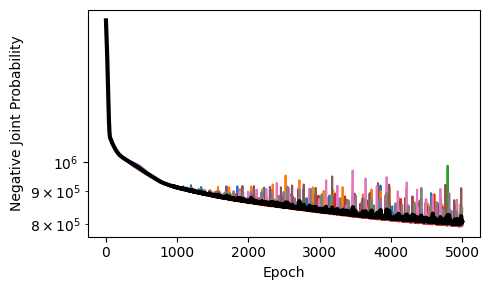

In [ ]:
# Inspect the training loss for each particle.
import matplotlib.pyplot as plt
losses = np.row_stack(model.losses_)
fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)
ax.plot(losses.T)
ax.plot(np.mean(losses, axis=0), color='k', linewidth=3)
ax.set_xlabel('Epoch')
ax.set_ylabel('Negative Joint Probability')
ax.set_yscale('log', base=10)

## Making Predictions

The `predict` method takes in

1. a test data frame, with the same format as the training data frame, except without the target column;

2. quantiles, which are a list of numbers between 0 and 1.

It returns mean predictions `yhat` and the requested quantiles `yhat_quantiles`. The `yhat` estimates are returned separately for each member of the ensemble whereas the `yhat_quantiles` estimates are computed across the entire ensemble.

In [ ]:
#!wget -q https://cs.cmu.edu/~fsaad/assets/bayesnf/air_quality.5.test.csv
!wget -q https://raw.githubusercontent.com/yadavrishikesh/BayesNF/main/data/air_quality.5.test.csv
df_test = pd.read_csv('air_quality.5.test.csv', index_col=0, parse_dates=['datetime'])
yhat, yhat_quantiles = model.predict(df_test, quantiles=(0.025, 0.5, 0.975))

It is helpful to show a scatter plot of the true vs predicted values on the test data. We will plot the median predictions `yhat_quantiles[1]` versus the true chickenpox value.

Text(0, 0.5, 'Predicted Value')

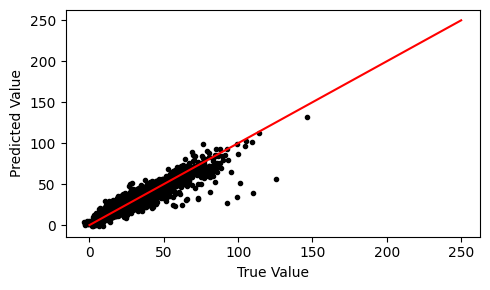

In [ ]:
fig, ax = plt.subplots(figsize=(5,3), tight_layout=True)
ax.scatter(df_test.pm10, yhat_quantiles[1], marker='.', color='k')
ax.plot([0, 250], [0, 250], color='red')
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')

We can also show the forecats on the held-out data for each of the four counties in the test set.

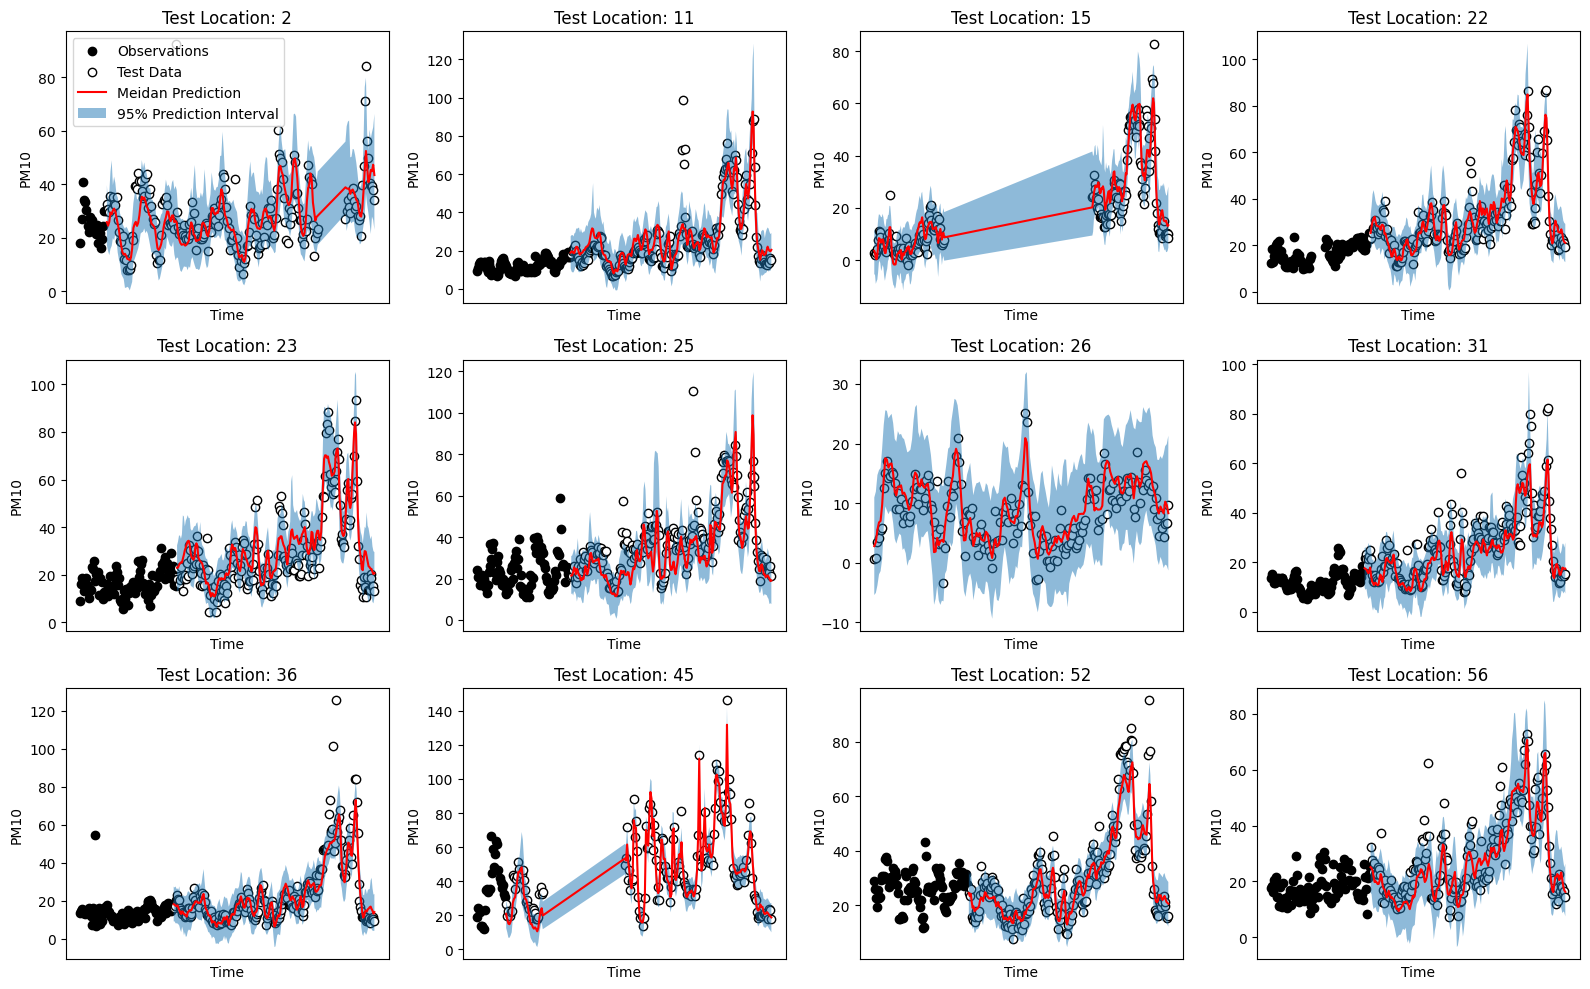

In [ ]:
locations = df_test.location.unique()
fig, axes = plt.subplots(ncols=4, nrows=len(locations)//4, tight_layout=True, figsize=(16,10))
for ax, location in zip(axes.flat, locations):
  y_train = df_train[df_train.location==location]
  y_test = df_test[df_test.location==location]
  ax.scatter(y_train.datetime[-100:], y_train.pm10[-100:], marker='o', color='k', label='Observations')
  ax.scatter(y_test.datetime, y_test.pm10, marker='o', edgecolor='k', facecolor='w', label='Test Data')
  mask = df_test.location.to_numpy() == location
  ax.plot(y_test.datetime, yhat_quantiles[1][mask], color='red', label='Meidan Prediction')
  ax.fill_between(y_test.datetime, yhat_quantiles[0][mask], yhat_quantiles[2][mask], alpha=0.5, label='95% Prediction Interval')
  ax.set_title('Test Location: %s' % (location,))
  ax.set_xticks([])
  ax.set_xlabel('Time')
  ax.set_ylabel('PM10')
axes.flat[0].legend(loc='upper left')